In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import gc
import h5py
import wandb
import sys
import matplotlib.pyplot as plt 
from tensorflow.keras.models import load_model
from dotenv import load_dotenv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [2]:
load_dotenv()  # Load environment variables from .env file
api_key = os.getenv("WANDB_API_KEY")

wandb.login(key=api_key)  # Login with the API key
wandb.init(project="LEC_FER2013", entity=os.getenv("WANDB_USERNAME"))

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nicholas66. Use `wandb login --relogin` to force relogin


In [3]:
def load_data(hdf5_file, dataset_name_images, dataset_name_labels):
    with h5py.File(hdf5_file, 'r') as hf:
        data = np.array(hf[dataset_name_images])
        labels = np.array(hf[dataset_name_labels])
    return data, labels

# Load data
data, labels = load_data('output files/fer2013_processed.h5', 'fer2013_images', 'fer2013_labels')

# Print shapes to verify
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

# Ensure that data and labels are not empty
assert len(data) > 0, "Data is empty."
assert len(labels) > 0, "Labels are empty."

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    data, 
    labels, 
    test_size=0.2, 
    stratify=labels
)

# Print shapes of the split data
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")

Data shape: (28709, 224, 224, 3)
Labels shape: (28709,)
Training data shape: (22967, 224, 224, 3)
Training labels shape: (22967,)
Validation data shape: (5742, 224, 224, 3)
Validation labels shape: (5742,)


In [4]:
# Define the data augmentation transformations
train_datagen = ImageDataGenerator(
    rotation_range=20,         # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,    # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,           # Randomly apply shearing transformation
    zoom_range=0.2,            # Randomly zoom images by up to 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Strategy for filling in newly created pixels
)

# Create data generator for training data
train_generator = train_datagen.flow(
    X_train,   # Training images
    y_train,   # Training labels
    batch_size=64  # Batch size for training
)

validation_datagen = ImageDataGenerator()

# Create data generator for validation data
validation_generator = validation_datagen.flow(
    X_val,  # Validation images
    y_val,  # Validation labels
    batch_size=64   # Batch size for validation
)


# Teacher Model

In [5]:
# def create_teacher_model():
#     base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     base_model.trainable = False  # Freeze the EfficientNet model
    
#     # Build teacher model
#     model = Sequential([
#         base_model,
#         GlobalAveragePooling2D(),
#         Dense(128, activation='relu'),
#         Dense(64, activation='relu'),
#         Dense(7, activation='softmax')  # 7 emotion classes
#     ])
#     return model

def create_teacher_model():
    # Load the local MobileNetV3 model
    model = load_model("Trained Model/Teacher_MobileNetV3Large_model_no_lyrs.keras")
    model.trainable = False  # Freeze the model layers
    
    return model

# LEC Model (Student)

In [6]:
def create_student_model():
    # Load MobileNetV3 as base model
    base_model = MobileNetV3Small(weights=None, include_top=False, input_shape=(224, 224, 3))
    
    # Freeze initial layers
    for layer in base_model.layers:  # Adjust the range as needed
        layer.trainable = True
    
    # Build the custom top layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')  # Assuming 7 emotion classes
    ])

    return model



In [7]:
teacher_model = create_teacher_model()
student_model = create_student_model()

# Custom callback for WandB
class WandBCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log({
            "Training Loss": logs.get("loss"),
            "Training Accuracy": logs.get("accuracy"),
            "Val Loss": logs.get("val_loss"),
            "Val Accuracy": logs.get("val_accuracy"),
            "epoch": epoch + 1
        })



        

# Define the knowledge distillation loss function
def knowledge_distillation_loss(y_true, y_pred, teacher_logits, T=3, alpha=0.5):
    
    # Hard loss (real labels)
    hard_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    # Soft loss (teacher predictions)
    soft_loss = KLDivergence()(
        tf.nn.softmax(teacher_logits / T),
        tf.nn.softmax(y_pred / T)
    )
    # Combined loss
    return alpha * hard_loss + (1 - alpha) * soft_loss


In [8]:
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',  # Metric to monitor, e.g., validation loss
#     factor=0.5,          # Factor by which the learning rate will be reduced
#     patience=5,          # Number of epochs with no improvement before reducing LR
#     min_lr=1e-8,         # Lower bound for the learning rate
# )

from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch > 0 and epoch % 20 == 0:  # Every 20 epochs
        return lr * 0.5                # Reduce LR by factor of 0.5
    return lr

reduce_lr = LearningRateScheduler(scheduler, verbose=1)

In [9]:
# Custom training step for batch-wise teacher logits
class CustomDistillationModel(tf.keras.Model):
    def __init__(self, student, teacher):
        super(CustomDistillationModel, self).__init__()
        self.student = student
        self.teacher = teacher

    def call(self, inputs, training=False):
        return self.student(inputs, training=training)

    def train_step(self, data):
        x, y_true = data
        
        # Get teacher predictions for the current batch
        teacher_logits = self.teacher(x, training=False)
        # tf.print("Sample teacher_logits:", teacher_logits[:5])

        with tf.GradientTape() as tape:
            # Student predictions
            y_pred = self.student(x, training=True)
            # Compute the KD loss
            loss = knowledge_distillation_loss(y_true, y_pred, teacher_logits)

        # Compute gradients and update weights
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics (accuracy)
        self.compiled_metrics.update_state(y_true, y_pred)

        logs = {m.name: m.result() for m in self.metrics}

        return logs

# Create the custom KD model
distilled_model = CustomDistillationModel(student_model, teacher_model)

# Compile the student model (no need to modify the WandB callback)
distilled_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fit the model as before



In [10]:
history = distilled_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[WandBCallback(), reduce_lr],  # Add reduce_lr callback here
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/100


n:\Thesis 2\Code\myenv\lib\site-packages\keras\src\backend\tensorflow\trainer.py:578: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(
n:\Thesis 2\Code\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 2:13:11 22s/step - accuracy: 0.1250 - loss: 0.142 ━━━━━━━━━━━━━━━━━━━━ 11:12 2s/step - accuracy: 0.1328 - loss: 0.1429  ━━━━━━━━━━━━━━━━━━━━ 10:58 2s/step - accuracy: 0.1319 - loss: 0.14 ━━━━━━━━━━━━━━━━━━━━ 10:55 2s/step - accuracy: 0.1312 - loss: 0.14 ━━━━━━━━━━━━━━━━━━━━ 10:50 2s/step - accuracy: 0.1306 - loss: 0.14 ━━━━━━━━━━━━━━━━━━━━ 10:47 2s/step - accuracy: 0.1305 - loss: 0.14 ━━━━━━━━━━━━━━━━━━━━ 10:44 2s/step - accuracy: 0.1300 - loss: 0.14 ━━━━━━━━━━━━━━━━━━━━ 10:48 2s/step - accuracy: 0.1297 - loss: 0.14 ━━━━━━━━━━━━━━━━━━━━ 10:46 2s/step - accuracy: 0.1297 - loss: 0.14 ━━━━━━━━━━━━━━━━━━━━ 10:45 2s/step - accuracy: 0.1308 - loss: 0.14 ━━━━━━━━━━━━━━━━━━━━ 10:47 2s/step - accuracy: 0.1314 - loss: 0.14 ━━━━━━━━━━━━━━━━━━━━ 10:50 2s/step - accuracy: 0.1325 - loss: 0.14 ━━━━━━━━━━━━━━━━━━━━ 10:58 2s/step - accuracy: 0.1335 - loss: 0.14 ━━━━━━━━━━━━━━━━━━━━ 10:54 2s/step - accuracy: 0.1345 - loss: 0.14 ━━━━━━━━━━━━━━━━━━━━ 10:51 2s/step - accuracy: 

In [11]:
student_model.save('Trained Model/LEC_model_no_TL.keras')


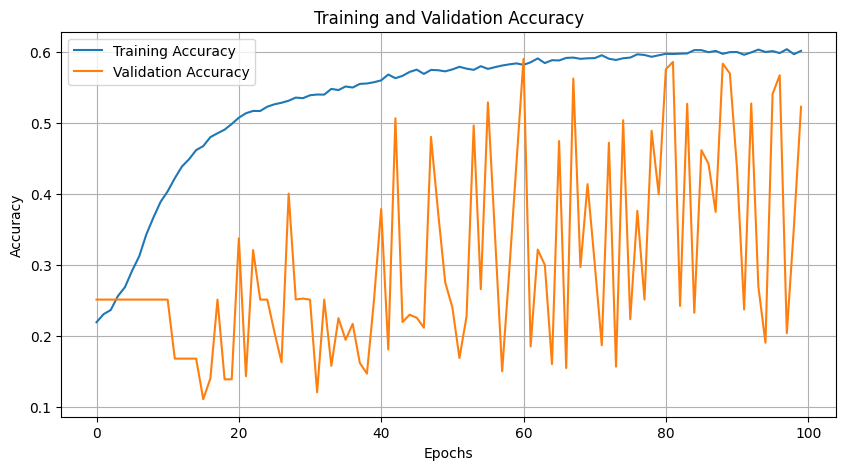

In [12]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))  # Create a new figure for the plot
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Training and Validation Accuracy')  # Title of the plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Show legend
plt.grid()  # Show grid
plt.show()  # Display the plot